# Final non-word stimuli generation from manually-curated Phrase/Non-Phrase stimuli

We perform the following steps for both the even and odd subject lists:
1. Pull a list of nouns not yet used in the P & NP conditions
2. Select a set of paired word and cluster lengths (3-5 characters) that match the frequencies of the P/NP conditions (equal numbers of 5, 4, and 3 character strings)
3. Randomly assign one of each pair to be the noun, the other the consonant cluster
4. Go through the list generating stimuli

We will only use **nouns** for the word component of the non-word pairs. This is because I want to avoid the subjects treating the consonant cluster as a semantic placeholder when reading. E.g. when reading "the zxdf" it is tempting to think of the zxdf as some object with an unpronounceable name. This problem will still occur with nouns, especially when the noun comes second ("zxdf boat"), but I believe subjects are less likely to assign a placeholder meaning to a word preceding a noun as opposed to following a determiner or adjective.

## Step 1:


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)


# Load in Nina's final stimuli lists and the consonants
stimpath = Path("../../word_ngrams/").resolve()
pnp_stim_even = pd.read_csv(stimpath / "final_P_NP_evensubs.csv").drop(columns=["Unnamed: 0"])
pnp_stim_odd = pd.read_csv(stimpath / "final_P_NP_oddsubs.csv").drop(columns=["Unnamed: 0"])
pnp_stim = pd.concat([pnp_stim_even, pnp_stim_odd]).reset_index(drop=True)
cons = pd.read_csv(stimpath / "cons_clust_final_candidates.csv").set_index(["clus1", "clus2"])

# Load in the core list of all words, isolate by nouns
wordcats = pd.read_csv(stimpath / "1grams_english_1b_with_pos.csv").convert_dtypes()

# Isolate the words which are nouns in the top 45k
wordcats["word"] = wordcats["ngram"].str.split("_").str[0]
wordcats = wordcats[~wordcats["word"].str.isupper()].reset_index(drop=True)
wordcats["POS"] = wordcats["ngram"].str.split("_").str[1]
wordcats.drop(columns=["ngram"], inplace=True)
wordcats = wordcats.reindex(columns=["word", "POS", "freq"])
nouns = wordcats[wordcats["POS"] == "NOUN"].reset_index(drop=True)

# Isolate the nouns not yet in the stimuli lists
pnp_stim_words = pd.melt(pnp_stim[["w1", "w2"]], ignore_index=False).reset_index(drop=False)
remidx = ~nouns["word"].isin(pnp_stim_words["value"])
candidates = nouns[remidx].reset_index(drop=True).copy()
print(f"A total of {len(candidates)} nouns remain to be added to the stimuli lists:")

A total of 25658 nouns remain to be added to the stimuli lists:


## Step 2:

We find the length of all stimulus words for even and odd lists, and generate a frequency table. We want to match the non-word with the other stimuli pair-for-pair, i.e. from a table like this:

| w1 length | w2 length | condition | frequency |
| :---------: | :---------: | :---------: | :---------: |
| 3 | 3 | phrase | 5 |
| 3 | 4 | phrase | 15 |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |
| 5 | 4 | non-phrase | 8 |
| 5 | 5 | non-phrase | 6 |

we will divide the frequency by two to get the total of each pairing for the even and odd non-word condition.

We then use this frequency table to generate a list of target lengths of stimuli (w1 and w2 targets), and randomly select w1 or w2 for each to be the consonant cluster.

In [2]:
for table in [pnp_stim_even, pnp_stim_odd]:
    for word in ["w1", "w2"]:
        table[f"{word}_len"] = table[word].str.len()

freqs_odd = pnp_stim_odd[["condition", "w1_len", "w2_len"]].value_counts().sort_index()
freqs_even = pnp_stim_even[["condition", "w1_len", "w2_len"]].value_counts().sort_index()
print("Odd subject freqs:")
display(freqs_odd)
print("Even subject freqs:")
display(freqs_even)

Odd subject freqs:


condition   w1_len  w2_len
non-phrase  3       4         12
            4       3         12
                    4         36
phrase      3       4         12
            4       3         12
                    4         36
Name: count, dtype: int64

Even subject freqs:


condition   w1_len  w2_len
non-phrase  3       4         12
            4       3         12
                    4         36
phrase      3       4         12
            4       3         12
                    4         36
Name: count, dtype: int64

## Step 3:

Since the frequencies are exactly balanced between the two (nice work Nina!) we can just use one as a reference. We use that to generate a list of trial word lengths using only one condition, and then select half of the words to be consonant clusters. 

Note that we don't do this assignment randomly, since the list will be shuffled for each experiment, and just set the first half to be noun-first and the second to be consonant-first.

In [3]:
target_freqs = freqs_odd.copy().loc["phrase"]
target_freqs
rows = []
for idx, row in target_freqs.items():
    midpoint = int(row / 2)
    for i in range(row):
        w1_type, w2_type = ("noun", "cons") if i < midpoint else ("cons", "noun")
        rows.append({"w1_len": idx[0], "w2_len": idx[1], "w1_type": w1_type, "w2_type": w2_type})
stimuli_nw = pd.DataFrame(rows)
print("Our final labels have the following distribution:")
display(stimuli_nw.value_counts().sort_index())

Our final labels have the following distribution:


w1_len  w2_len  w1_type  w2_type
3       4       cons     noun        6
                noun     cons        6
4       3       cons     noun        6
                noun     cons        6
        4       cons     noun       18
                noun     cons       18
Name: count, dtype: int64

## Step 4:

We finally generate the stimuli from each trial by using a list of 120 nouns (60 for even, 60 for odd) and 60 consonant clusters (re-used between even/odd) and the assignments from earlier.

We choose the nouns to have a similar frequency distribution to those used in the phrase/non-phrase conditions, so we first need to see those distributions. We then sample target frequencies for the 120 nouns from the stimuli distribution, and choose the nouns closest to those targets with a specified length.

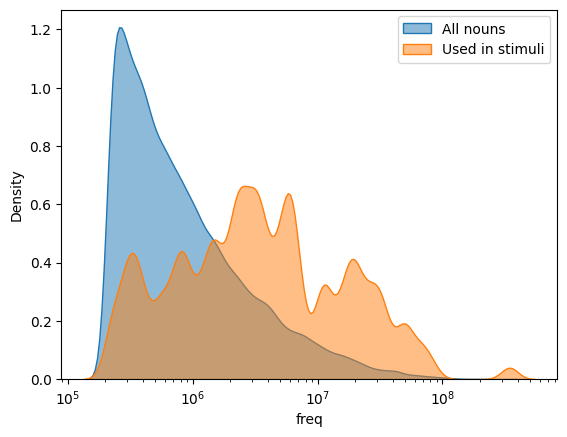

In [4]:
# start by visualizing the distribution of all noun frequencies and those used in the stimuli
kernwidth = 0.1
sns.kdeplot(
    data=nouns,
    x="freq",
    fill=True,
    label="All nouns",
    alpha=0.5,
    log_scale=True,
    bw_method=kernwidth,
)
sns.kdeplot(
    data=nouns[~remidx],
    x="freq",
    fill=True,
    label="Used in stimuli",
    alpha=0.5,
    log_scale=True,
    bw_method=kernwidth,
)
plt.legend()

In [ ]:
def is_good_word(word):
    if not all(c.isalpha() for c in word):
        return False
    else:
        return True


def get_nearest_word(candidates, target_f):
    nearest_idx = np.abs(candidates["freq"] - target_f).idxmin()
    return candidates.loc[nearest_idx]["word"], nearest_idx


def get_nearest_good(candidates, length, target_f):
    lencand = candidates[candidates["word_len"] == length]
    nearest_word, nearest_idx = get_nearest_word(lencand, target_f)
    return nearest_word, nearest_idx


freq_samples = rng.choice(nouns[~remidx]["freq"], size=120, replace=False).tolist()

# nouns by length
candidates.loc[:, "word_len"] = candidates["word"].str.len()
candidates = candidates[candidates["word_len"].isin((3, 4))].copy()
candidates["word"] = candidates["word"].str.lower()
candidates = candidates.drop_duplicates(subset="word").reset_index(drop=True)
candidates.loc[:, [f"cand{i}" for i in range(8)]] = ""

# Generate two sets to fill
stimuli_nw["w1"] = ""
stimuli_nw["w2"] = ""
stimuli_nw_odd = stimuli_nw.copy()
stimuli_nw_even = stimuli_nw.copy()
for idx, row in stimuli_nw_odd.iterrows():
    for word in ["w1", "w2"]:
        if row[f"{word}_type"] == "noun":
            wordlen = row[f"{word}_len"]
            for stimtable in [stimuli_nw_odd, stimuli_nw_even]:
                freq = freq_samples.pop()
                for i in range(8):
                    stimtable.at[idx, f"cand{i}"], nearest_idx = get_nearest_good(
                        candidates, wordlen, freq
                    )
                    candidates.drop(index=nearest_idx, inplace=True)

display(stimuli_nw_even.head(10))
allopts = pd.melt(stimuli_nw_even[[f"cand{i}" for i in range(8)]]).reset_index(drop=True)
display(allopts.value_counts("value").max())

ValueError: Cannot take a larger sample than population when replace is False

We only generated *candidate* words here, because so many of the options when using this sampling strategy are proper nouns or non-english words. We will choose manually the noun for each condition later. Now let's generate the consonant clusters:

In [6]:
cons_sample = cons.sample(frac=1)["non_word"].to_list()
print(len(cons_sample))
considx = 0
for idx, row in stimuli_nw_odd.iterrows():
    for word in ["w1", "w2"]:
        if row[f"{word}_type"] == "cons":
            wordlen = row[f"{word}_len"]
            for stimtable in [stimuli_nw_odd, stimuli_nw_even]:
                stimtable.at[idx, word] = cons_sample[idx][:wordlen]
                considx += 1
display(stimuli_nw_even.head(10))
stimuli_nw_even.loc[:, "subtype"] = "even"
stimuli_nw_odd.loc[:, "subtype"] = "odd"
stimuli_nw = pd.concat([stimuli_nw_even, stimuli_nw_odd]).reset_index(drop=True)
stimuli_nw.to_csv(stimpath / "final_nw_stimuli.csv")

96


,w1_len,w2_len,w1_type,w2_type,w1,w2,cand0,cand1,cand2,cand3,cand4,cand5,cand6,cand7
0,3,4,noun,cons,,kvzk,say,hem,exp,nut,mit,mel,mon,ivy
1,3,4,noun,cons,,mksj,fur,tin,doc,net,ted,jet,nod,edn
2,3,4,noun,cons,,bkvj,fat,pop,toe,toy,bid,ron,cal,tel
3,3,4,noun,cons,,mvhk,pam,saw,vii,rum,gil,sen,fri,vow
4,3,4,noun,cons,,fkxj,our,mum,rod,two,jay,app,low,gut
5,3,4,noun,cons,,jkzm,lid,arc,rob,pat,gen,bin,jew,cab
6,3,4,cons,noun,qvx,,greg,fury,cart,aims,nuts,fair,ribs,seal
7,3,4,cons,noun,hkj,,cost,loss,text,plan,test,fire,half,week
8,3,4,cons,noun,mkq,,skin,step,paul,rest,look,king,news,arms
9,3,4,cons,noun,tjp,,rays,hint,dean,biol,cape,gray,beds,tips


Now we make a nice little interactive widget to select among the candidates for each pair

In [7]:
from ipywidgets import interact_manual, RadioButtons

idx = 0
candidates = stimuli_nw.loc[idx, [f"cand{i}" for i in range(8)]].str.lower().to_list()
radio = RadioButtons(options=candidates, description="Word choices:", disabled=False)


def write_choice(user_choice):
    global idx
    curr_row = stimuli_nw.loc[idx]
    word = "w1" if curr_row.w1_type == "noun" else "w2"
    stimuli_nw.at[idx, word] = user_choice.lower()
    idx += 1
    global candidates
    global radio
    try:
        candidates = stimuli_nw.loc[idx, [f"cand{i}" for i in range(8)]].str.lower().to_list()
        radio.options = candidates
    except IndexError:
        print("All words have been chosen.")
    return


interact_manual(write_choice, user_choice=radio)

interactive(children=(RadioButtons(description='Word choices:', options=('say', 'hem', 'exp', 'nut', 'mit', 'm…

<function __main__.write_choice(user_choice)>

In [164]:
stimuli_nw.drop(columns=[f"cand{i}" for i in range(8)]).to_csv(
    stimpath / "final_for_real_actually_V2_NW_stimuli.csv"
)